### BD5write_timeseries_point

BD5write_timeseries_point is a sample code to demonstrate how to image process a series of images and put them into a BD5 file. 

* The sample code reads in a couple of images. It then segmented the objects within the images, find their contours and calculate their centroids. 
* It then saves the centroids as points in the BD5 file.
* It tries to track the objects between time points by finding the closest objects between two time points.
* It then records the object pairs into trackInfo dataset in the BD5 file before closing it.

This sample code requires the user to install several packages. They are:

- Pytables - http://www.pytables.org/index.html
- Numpy - https://numpy.org/
- OpenCV - https://opencv.org/
- SciPy - https://www.scipy.org/

In [1]:
# Please consult the official websites for installation for your particular Operating system and environment.
# The following commands installed the necessary packages for juypter notebook in a Ubuntu docker container as a sample for your reference.

# Uncomment the # tag if you want the commands below to install those packages.

#!pip install tables

#!pip install numpy

#!pip install opencv-python

#!pip install scipy

In [2]:
# Original Author: Koji Kyoda
# Contributor: Ken ho 
# Date: 19 June 2020

import sys
import tables
from tables import *
import numpy as np
import cv2
import math
import warnings
import matplotlib.pyplot as plt


# for supression of natural name warning
warnings.filterwarnings('ignore', category=tables.NaturalNameWarning)


In [3]:
# This sample code also uses scipy distance to calculate the distance of two points.

from scipy.spatial import distance

In [4]:
# class definition
class ScaleUnit(IsDescription):
    dimension = StringCol(8, dflt="", pos=0)
    xScale = Float64Col(dflt=0, pos=1)
    yScale = Float64Col(dflt=0, pos=2)
    sUnit = StringCol(16, dflt="", pos=3)
    tScale = Float64Col(dflt=0, pos=4)
    tUnit = StringCol(16, dflt="", pos=5)

class ObjectDef(IsDescription):
    oID = UInt16Col(dflt=0, pos=0)
    name = StringCol(128, dflt="", pos=1)

class Data(IsDescription):
    ID = StringCol(32, dflt="", pos=0)
    t = Int32Col(dflt=0, pos=1)
    entity = StringCol(8, dflt="", pos=2)
    x = Float32Col(dflt=0, pos=3)
    y = Float32Col(dflt=0, pos=4)
#    radius = Float32Col(dflt=0, pos=5)


## Preprocess the images
* Read in the images as img1 and img2
* Convert the image into a grayscale image
* Thresholding the image
* Finding the contours of the ROIs

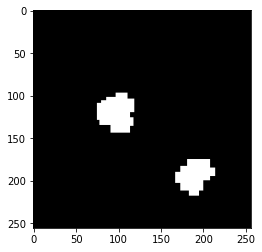

In [5]:
# input image_1
img_path1 = "./bw_sample02.tif"
img1 = cv2.imread(img_path1)
imgray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray1, 'gray')

In [6]:
# preprocessing
ret,thresh1 = cv2.threshold(imgray1,127,255,0)

In [7]:
# find contours of ROIs
contours1, hierarchy1 = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [8]:
# finding the size of the image
height, width, channel = img1.shape
img1.shape

(256, 256, 3)

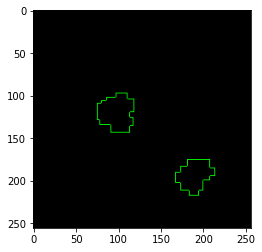

In [9]:
# creating a background image with the same dimension
bkimage1 = np.zeros((height, width, channel), np.uint8)

# plot the contours over the background image
cv2.drawContours(bkimage1, contours1, -1, (0, 255, 0), 1) 
plt.imshow(bkimage1)

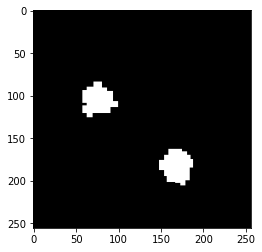

In [10]:
# input image_2
img_path2 = "./bw_sample03.tif"
img2 = cv2.imread(img_path2)
imgray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
plt.imshow(imgray2, 'gray')

In [11]:
# preprocessing
ret,thresh2 = cv2.threshold(imgray2,127,255,0)

In [12]:
# find contours of ROIs
contours2, hierarchy2 = cv2.findContours(thresh2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

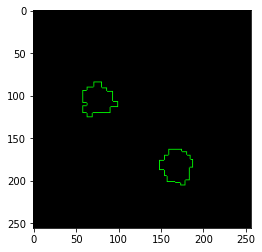

In [13]:
# creating a background image with the same dimension
bkimage2 = np.zeros((height, width, channel), np.uint8)

# plot the contours over the background image
cv2.drawContours(bkimage2, contours2, -1, (0, 255, 0), 1) 
plt.imshow(bkimage2)

### Main routines to output the data into a BD5 format file

In [14]:
# output

hdf5_out = "./sample_timeseries_point_bd5.h5"


In [15]:
# output to bd5 file
bd5file = open_file(hdf5_out, mode="w", title="bd5 file")
group = bd5file.create_group('/', 'data', 'data group')

# for scaleUnit
scaleunit = bd5file.create_table('/data', 'scaleUnit', ScaleUnit, "definition of scale and unit")
su = scaleunit.row
su['dimension'] = "2D+T"
su['xScale'] = 0.1
su['yScale'] = 0.1
su['sUnit'] = "micrometer"
su['tScale'] = 1
su['tUnit'] = "minute"
su.append()
scaleunit.flush()

# for objectDef
objectdef = bd5file.create_table('/data', 'objectDef', ObjectDef, "object definition")
od = objectdef.row
od['oID'] = 0
od['name'] = "nucleus"
od.append()
objectdef.flush()

# series index
series = bd5file.create_group('/data', '0', 'time series index 0')
series = bd5file.create_group('/data', '1', 'time series index 1')

# object - create a HDF datagroup under time series index as object using pytable h5file.create_group
object1 = bd5file.create_group('/data/0', 'object', 'object0') 
object2 = bd5file.create_group('/data/1', 'object', 'object1')


In [16]:
# store xy coordinates to dataset table for time series index 0
# It also uses a list trackxy0 to store the coordinates for tracking objects over the time points.
trackxy0 = []
table = bd5file.create_table('/data/0/object', '0', Data, "dataset")
xyz = table.row
for i, cnt in enumerate(contours1):
    M = cv2.moments(cnt)
    cx = M['m10'] / M['m00']
    cy = M['m01'] / M['m00']
    xyz['ID'] = "o000" + '%03d' % i
    xyz['t'] = 0
    xyz['entity'] = 'point'
    xyz['x'] = cx
    xyz['y'] = cy
    xyz.append()
    trackxy0.append(("o000" + '%03d' % i, 0, (cx, cy)) )
table.flush()


In [17]:
# store xy coordinates to dataset table for time series index 1
# It also uses a list trackxy1 to store the coordinates for tracking objects over the time points.

trackxy1 = []
table = bd5file.create_table('/data/1/object', '0', Data, "dataset")
xyz = table.row
for i, cnt in enumerate(contours2):
    M = cv2.moments(cnt)
    cx = M['m10'] / M['m00']
    cy = M['m01'] / M['m00']
    xyz['ID'] = "o000" + '%03d' % i
    xyz['t'] = 1
    xyz['entity'] = 'point'
    xyz['x'] = cx
    xyz['y'] = cy
    xyz.append()
    trackxy1.append(("o001" + '%03d' % i, 1, (cx, cy)) )
table.flush()


In [18]:
trackxy0

[('o000000', 0, (189.30436507936508, 193.9308201058201)),
 ('o000001', 0, (97.73062079611863, 120.28172896681))]

In [19]:
trackxy1

[('o001000', 1, (168.3367092323499, 182.9292528988698)),
 ('o001001', 1, (75.66309412861138, 105.1637154395775))]

### Tracking the objects over two time points

In [20]:
# It uses a list track to store all the distances between objects of two time points.

track = []
for i in trackxy0:
    for j in trackxy1:
        dst = distance.euclidean(i[2], j[2])
        track.append((i, j, dst))

In [21]:
track

[(('o000000', 0, (189.30436507936508, 193.9308201058201)),
  ('o001000', 1, (168.3367092323499, 182.9292528988698)),
  23.678620583300745),
 (('o000000', 0, (189.30436507936508, 193.9308201058201)),
  ('o001001', 1, (75.66309412861138, 105.1637154395775)),
  144.20103097457482),
 (('o000001', 0, (97.73062079611863, 120.28172896681)),
  ('o001000', 1, (168.3367092323499, 182.9292528988698)),
  94.39243602684972),
 (('o000001', 0, (97.73062079611863, 120.28172896681)),
  ('o001001', 1, (75.66309412861138, 105.1637154395775)),
  26.749393754452235)]

In [22]:
# Sorting the list track

strack = sorted(track, key=lambda x: x[-1])

In [23]:
strack

[(('o000000', 0, (189.30436507936508, 193.9308201058201)),
  ('o001000', 1, (168.3367092323499, 182.9292528988698)),
  23.678620583300745),
 (('o000001', 0, (97.73062079611863, 120.28172896681)),
  ('o001001', 1, (75.66309412861138, 105.1637154395775)),
  26.749393754452235),
 (('o000001', 0, (97.73062079611863, 120.28172896681)),
  ('o001000', 1, (168.3367092323499, 182.9292528988698)),
  94.39243602684972),
 (('o000000', 0, (189.30436507936508, 193.9308201058201)),
  ('o001001', 1, (75.66309412861138, 105.1637154395775)),
  144.20103097457482)]

In [24]:
# We assume that the object will only have one corresponding object in the next time point
# Here we eliminate any duplicate objects in the list 
rtrack = []
found = False
for i in strack: 
    if rtrack == []:
        rtrack.append(i)
    else:
        for j in rtrack:
            if i[0] == j[0]: 
                found = True
        if found == False:
            rtrack.append(i)

In [25]:
rtrack

[(('o000000', 0, (189.30436507936508, 193.9308201058201)),
  ('o001000', 1, (168.3367092323499, 182.9292528988698)),
  23.678620583300745),
 (('o000001', 0, (97.73062079611863, 120.28172896681)),
  ('o001001', 1, (75.66309412861138, 105.1637154395775)),
  26.749393754452235)]

### Writing the trackInfo into BD5 file

In [26]:
# setting up datatype for trackInfo
trackInfo_descr = np.dtype({'names': ['from','to'],
               'formats': ['S8', 'S8']})

In [27]:
trackinfo = bd5file.create_table('/data', 'trackInfo', trackInfo_descr)
for i in rtrack:
    trackinfo_row = trackinfo.row
    trackinfo_row['from'] = i[0][0]
    trackinfo_row['to'] = i[1][0]
    trackinfo_row.append()
    trackinfo.flush()

In [28]:
# Closing the output BD5 file
bd5file.close()

### Plotting out the contours and tracking of the centroids.

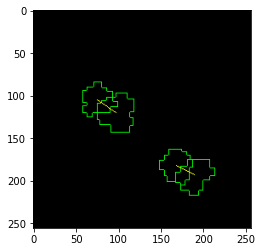

In [30]:
# creating a background image with the same dimension
bkimage = np.zeros((height, width, channel), np.uint8)

# plot the contours over the background image
cv2.drawContours(bkimage, contours1, -1, (0, 255, 0), 1) 
cv2.drawContours(bkimage, contours2, -1, (0, 255, 0), 1) 
for i in rtrack:
    x1 = int(i[0][2][0])
    y1 = int(i[0][2][1])
    x2 = int(i[1][2][0])
    y2 = int(i[1][2][1])
    cv2.line(bkimage, (x1, y1), (x2, y2), (255, 255, 0), thickness=1)
plt.imshow(bkimage)